In [1]:
import numpy as np
from scipy.io import loadmat
from scipy import signal, stats, fft
import matplotlib.pyplot as plt 

Load in vivo data

In [2]:
datafile = "/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat"
data = loadmat(datafile)

fs = data['fs'][0,0]
scale = data['scale'][0,0]
LFP_seg = [scale*x.ravel() for x in data['LFP_seg'].ravel()]

LFP_cat = np.concatenate(LFP_seg)

Get PSD of in vivo LFP and fit 1/f^a

In [3]:
nfft = 2**7 # 128 samples
print(LFP_cat.shape)

f, Pxx = signal.welch(LFP_cat, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')
f = f.ravel()

f_cutoff = max(np.argmax(Pxx),1)
Pmax = Pxx[f_cutoff]
idx = np.arange(f_cutoff,f.size)
result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
b = result.intercept
a = -result.slope

f_cutoff = np.exp((b-np.log(Pmax))/a)
idx = f>f_cutoff
Pfit = Pxx.copy()
Pfit[idx] = np.exp(b)/f[idx]**a
Pfit[~idx] = Pmax

(14628991,)


Normalization factors for fourier coefficients in the loss function

In [4]:
norm_factor = np.sqrt(Pmax/Pfit)
print(norm_factor)
# Using FFT with nfft
print(nfft)

[  1.           1.           1.66752787   2.77996143   3.99508404
   5.29276295   6.66026624   8.08870546   9.57147214  11.1034326
  12.68046743  14.29918756  15.95674887  17.6507257   19.37902136
  21.13980288  22.93145225  24.75252918  26.6017422   28.47792576
  30.38002191  32.30706547  34.25817177  36.23252662  38.2293778
  40.24802797  42.2878286   44.34817481  46.42850089  48.52827649
  50.64700321  52.7842117   54.93945909  57.11232666  59.3024179
  61.50935664  63.7327855   65.97236444  68.22776946  70.49869144
  72.78483513  75.08591813  77.40167009  79.73183188  82.07615489
  84.43440038  86.80633885  89.19174952  91.5904198   94.00214483
  96.42672703  98.86397575 101.31370681 103.77574224 106.24990992
 108.7360433  111.23398108 113.74356701 116.26464962 118.79708198
 121.3407215  123.89542975 126.46107225 129.03751829 131.6246408 ]
128


Define function for generating pink noise

In [5]:
def pink_noise(f, alpha=1., fmin=0):
    """
    f: normalized frequencies
    alpha: exponent of pink noise
    fmin: Low-frequency cutoff
    """
    S = 1/np.where(f == 0, float('inf'), f**(alpha/2))
    if fmin>0:
        S[(f<fmin) & (f!=0)] = fmin**(-alpha/2)
    return S

def noise_gen(N, psd = lambda f: 1):
    f = fft.rfftfreq(N)
    Scale = psd(f)
    w = Scale[1:].copy()
    w[-1] *= (1 + (N % 2)) / 2. # correct f = +-0.5
    sigma = 2 * np.sqrt(np.sum(w**2)) / N
    sr = Scale * np.random.randn(len(f))
    si = Scale * np.random.randn(len(f))
    if not (N % 2): si[-1] = 0 # If the signal length is even, frequencies +/- 0.5 are equal, the coefficient must be real.
    si[0] = 0 # Regardless of signal length, the DC component must be real
    s  = sr + 1J * si
    X = fft.irfft(s) / sigma
    return X

Generate pink noise and get its PSD

In [6]:
N = 2**((LFP_cat.size-1).bit_length()-1) # choose power of 2 samples
noise_psd = lambda f: pink_noise(f, alpha=a, fmin=f_cutoff/fs) # function for calculating noise psd
x_noise = np.std(LFP_cat) * noise_gen(N, psd = noise_psd)

_, Pxx_noi = signal.welch(x_noise, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')

# Compare power in each signal
print(np.std(LFP_cat))
print(np.std(x_noise))

164.52678640295144
164.65439891765814


Plot PSD

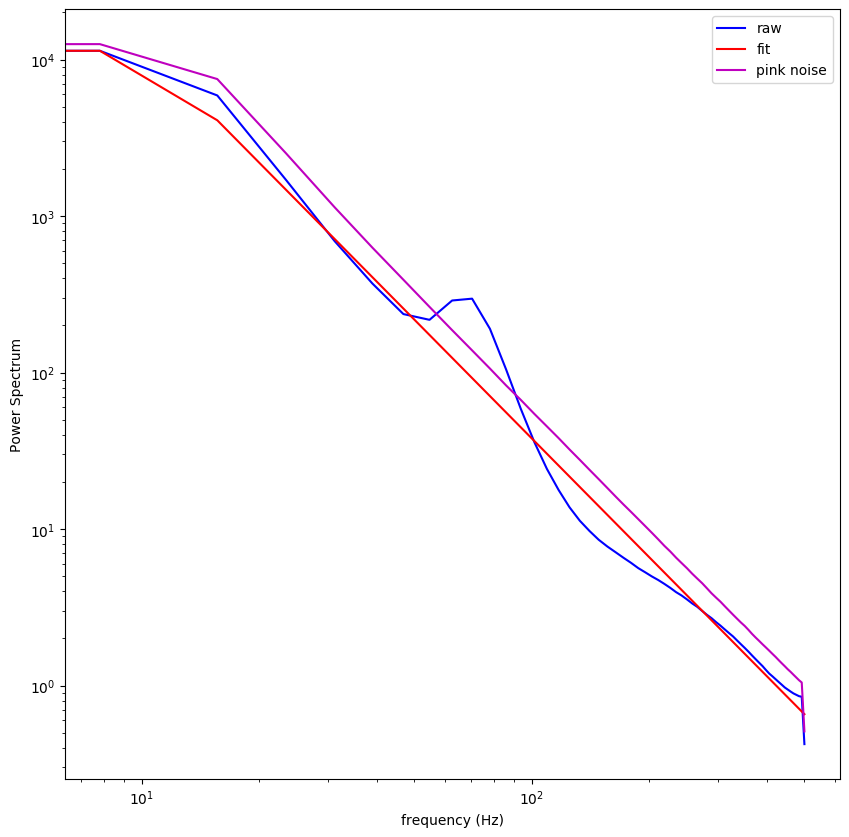

In [7]:
LinearScale = False

plt.figure(figsize=(10,10))
if LinearScale:
    plt.plot(f, Pxx, 'b', label='raw')
    plt.plot(f, Pfit, 'r', label='fit')
    plt.plot(f, Pxx_noi, 'm', label='pink noise')
else:
    plt.loglog(f, Pxx, 'b', label='raw')
    plt.loglog(f, Pfit, 'r', label='fit')
    plt.loglog(f, Pxx_noi, 'm', label='pink noise')
plt.xlabel("frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()

Plot example pink noise trace

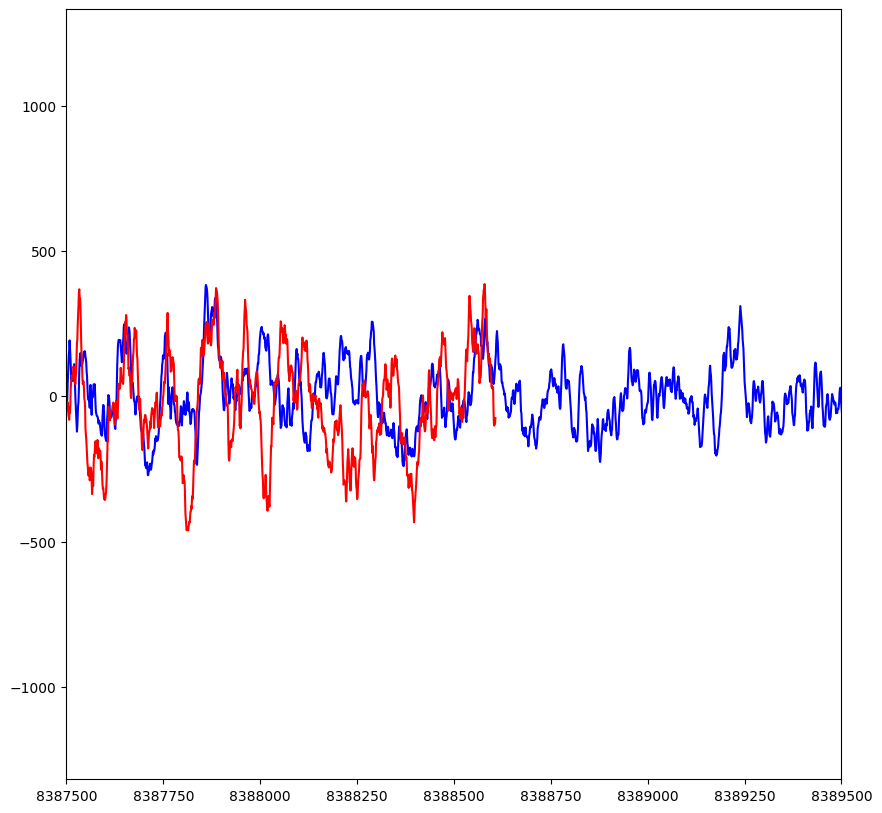

In [8]:
# %matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(LFP_cat, 'b')
ax.plot(x_noise, 'r')
ax.set_xlim(left=8.3875e6, right=8.3895e6)
plt.show()